# Fetch Rewards Machine Learning Take-Home Exercise

## 1. Introduction
In this notebook, we will develop a machine learning model to predict the monthly number of scanned receipts for Fetch Rewards based on 2021 data. 

The objective is to use an LSTM model, which is well-suited for handling time-series data, to forecast the receipts for the year 2022. We will walk through the following steps:
- Data loading and preprocessing
- Model implementation and training
- Hyperparameter tuning to find the best configuration
- Predictions and results visualization


## 2. Data Loading and Preprocessing

In this section, we will load the data provided in the CSV file and perform initial preprocessing steps. We'll aggregate the daily scanned receipts into monthly totals, as our model will predict monthly receipts.

### Steps:
1. Load the daily receipt data from the CSV file.
2. Resample the data to get monthly totals.
3. Visualize the monthly data to get an understanding of the trends in 2021.

In [46]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim


/var/folders/9j/4qhm498x25s5m7dmvf5wny7m0000gn/T/ipykernel_87544/3006207416.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = data['Receipt_Count'].resample('M').sum()


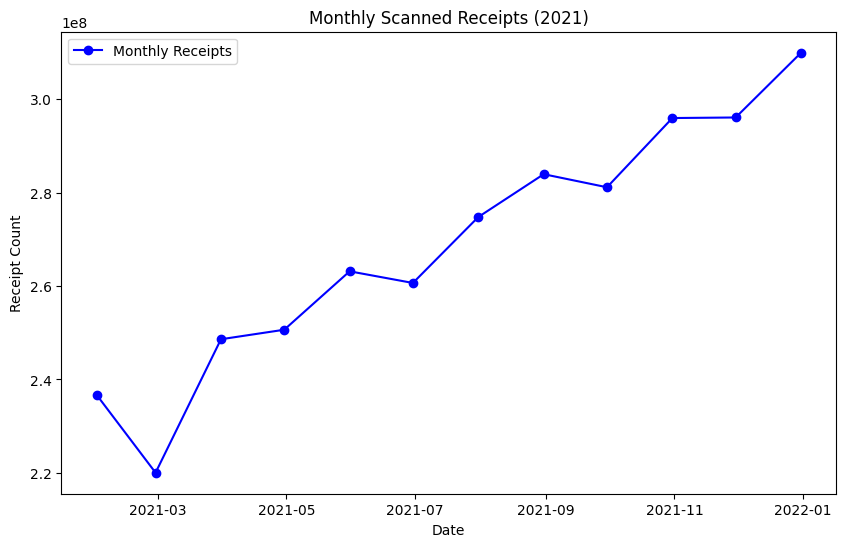

In [47]:
# Load the data
data = pd.read_csv('../data/data_daily.csv', parse_dates=['# Date'], index_col='# Date')

# Get monthly totals
monthly_data = data['Receipt_Count'].resample('M').sum()

# Visualize monthly receipt count
plt.figure(figsize=(10, 6))
plt.plot(monthly_data.index, monthly_data.values, label='Monthly Receipts', marker='o', color='blue')
plt.title('Monthly Scanned Receipts (2021)')
plt.xlabel('Date')
plt.ylabel('Receipt Count')
plt.legend()
plt.show()


## 3. Data Scaling

Since the data has varying ranges, we will scale the data to a range between 0 and 1. Scaling the data helps improve the convergence speed of neural network models. We will also define functions to scale and inverse scale the data.

### Steps:
1. Identify the minimum and maximum values in the data.
2. Scale the data to the range [0, 1] using the min-max scaling technique.
3. Define functions for scaling and inverse scaling.


In [48]:
# Scale the data
min_val = monthly_data.min()
max_val = monthly_data.max()

def custom_scale(data, min_val, max_val):
    return (data - min_val) / (max_val - min_val)

def custom_inverse_scale(scaled_data, min_val, max_val):
    return scaled_data * (max_val - min_val) + min_val

scaled_monthly_data = custom_scale(monthly_data.values, min_val, max_val)


## 4. Dataset Preparation (Manual Split)

Since we are avoiding the use of high-level libraries like `scikit-learn`, we will manually split the data into training and validation sets. We will allocate 80% of the data for training and the remaining 20% for validation.

### Steps:
- Create `X` as the month index and `y` as the scaled monthly receipt count.
- Manually split the data into training and validation sets based on the index.


In [49]:
# Prepare the dataset
X = np.array([[i] for i in range(1, len(scaled_monthly_data) + 1)])  # Month index
y = scaled_monthly_data

# Manually split the data into training and validation sets (80% train, 20% validation)
split_idx = int(0.8 * len(X))  # 80% split index

X_train, X_val = X[:split_idx], X[split_idx:]
y_train, y_val = y[:split_idx], y[split_idx:]

## 5. Convert Data into PyTorch Tensors

We need to convert the data into PyTorch tensors for use with the LSTM model. Since LSTMs expect 3D inputs, we add an extra dimension to represent time steps.


In [50]:
# Convert to PyTorch tensors and add dimensions for LSTM input
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1).to(device)  # Add dimension for LSTM
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)  # Add dimension for target

X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1).to(device)  # Add dimension for LSTM
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1).to(device)  # Add dimension for target


## 6. LSTM Model Definition

Define the LSTM model, which uses customizable hyperparameters: `input_size`, `hidden_size`, `output_size`, and `num_layers`. We will initialize the hidden and cell states (`h0`, `c0`) inside the `forward` function.


In [51]:
# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
    
    def forward(self, x):
        # Initialize hidden state and cell state with the correct size
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Take the last output
        return out


## 7. Hyperparameter Grid Search

We will implement a grid search to determine the best hyperparameters. The search will include variations of hidden sizes, number of layers, and learning rates. Each combination will be trained for a set number of epochs, and we will use early stopping to avoid overfitting.


In [55]:
from itertools import product

# Hyperparameter grid
hidden_sizes = [100, 500, 1000]
num_layers_list = [1, 2]
learning_rates = [0.001, 0.0005]
epochs = 50
patience = 10  # Early stopping patience
torch.manual_seed(42)
np.random.seed(42)


# Initialize variables for tracking the best model and validation loss
best_val_loss = float('inf')
best_hyperparameters = None
best_model_path = 'best_model.pth'

# Grid search over hyperparameters
for hidden_size, num_layers, learning_rate in product(hidden_sizes, num_layers_list, learning_rates):
    print(f'Training model with hidden_size={hidden_size}, num_layers={num_layers}, learning_rate={learning_rate}')
    
    # Initialize model and optimizer
    model = LSTMModel(input_size=1, hidden_size=hidden_size, output_size=1, num_layers=num_layers).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop with validation and early stopping
    train_losses = []
    val_losses = []
    early_stop_count = 0

    for epoch in range(epochs):
        model.train()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)
        
        train_losses.append(loss.item())
        val_losses.append(val_loss.item())
        
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}, Val Loss: {val_loss.item():.6f}')
        
        # Early stopping
        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            early_stop_count = 0
            best_hyperparameters = (hidden_size, num_layers, learning_rate)
            # Save the model with the best validation loss
            torch.save(model, best_model_path)
        else:
            early_stop_count += 1
            if early_stop_count >= patience:
                print(f"Early stopping at epoch {epoch+1}. Best validation loss: {best_val_loss:.6f}")
                break


Training model with hidden_size=100, num_layers=1, learning_rate=0.001
Epoch [10/50], Loss: 0.057185, Val Loss: 0.242811
Epoch [20/50], Loss: 0.013859, Val Loss: 0.056788
Epoch [30/50], Loss: 0.012121, Val Loss: 0.008403
Epoch [40/50], Loss: 0.011199, Val Loss: 0.009157
Early stopping at epoch 44. Best validation loss: 0.006407
Training model with hidden_size=100, num_layers=1, learning_rate=0.0005
Epoch [10/50], Loss: 0.119947, Val Loss: 0.469792
Early stopping at epoch 10. Best validation loss: 0.006407
Training model with hidden_size=100, num_layers=2, learning_rate=0.001
Epoch [10/50], Loss: 0.080113, Val Loss: 0.320701
Early stopping at epoch 10. Best validation loss: 0.006407
Training model with hidden_size=100, num_layers=2, learning_rate=0.0005
Epoch [10/50], Loss: 0.173473, Val Loss: 0.625205
Early stopping at epoch 10. Best validation loss: 0.006407
Training model with hidden_size=500, num_layers=1, learning_rate=0.001
Epoch [10/50], Loss: 0.029604, Val Loss: 0.062178
Early s

## 8. Load the Best Model and Evaluate

After completing the grid search, we will load the best-performing model and use it to predict the monthly receipt count for 2022.


In [56]:
# Load the best model after grid search
best_model = torch.load(best_model_path)

# Output the best hyperparameters
print(f"Best hyperparameters: hidden_size={best_hyperparameters[0]}, num_layers={best_hyperparameters[1]}, learning_rate={best_hyperparameters[2]}")

# Predict future months (for example, 2022)
with torch.no_grad():
    best_model.eval()
    future_months = np.array([[i] for i in range(len(monthly_data) + 1, len(monthly_data) + 13)])  # Predicting for 2022
    future_months_tensor = torch.tensor(future_months, dtype=torch.float32).unsqueeze(1).to(device)
    predicted_scaled_receipts = best_model(future_months_tensor).cpu().numpy()
    predicted_receipts = custom_inverse_scale(predicted_scaled_receipts, min_val, max_val)


Best hyperparameters: hidden_size=1000, num_layers=2, learning_rate=0.0005


## 9. Visualization of Predictions

We will visualize the comparison between the actual monthly receipt counts for 2021 and the predicted counts for 2022. This will help evaluate the model's performance and determine the accuracy of the predictions.


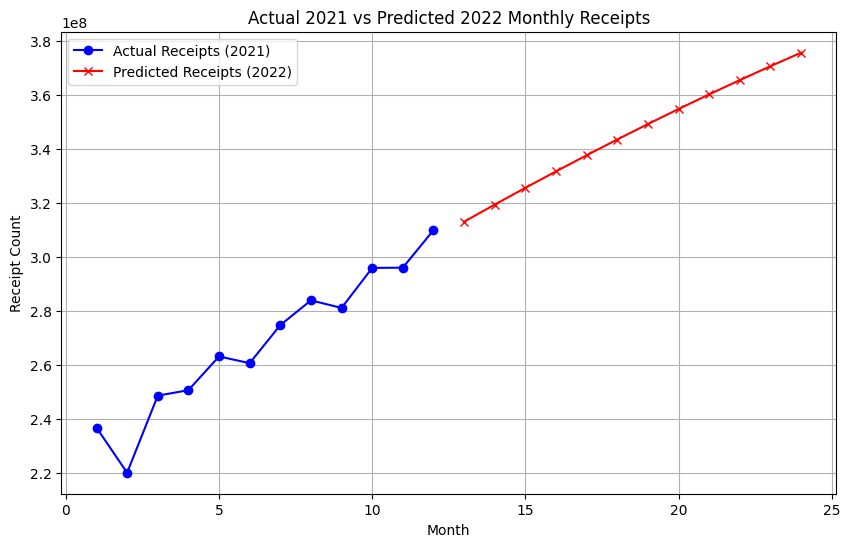

In [57]:
# Visualization: Actual 2021 vs Predicted 2022
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(monthly_data)+1), monthly_data.values, label='Actual Receipts (2021)', marker='o', color='blue')
plt.plot(range(len(monthly_data)+1, len(monthly_data)+13), predicted_receipts, label='Predicted Receipts (2022)', marker='x', color='red')
plt.title('Actual 2021 vs Predicted 2022 Monthly Receipts')
plt.xlabel('Month')
plt.ylabel('Receipt Count')
plt.grid(True)
plt.legend()
plt.show()


/var/folders/9j/4qhm498x25s5m7dmvf5wny7m0000gn/T/ipykernel_87544/2739242464.py:11: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = data['Receipt_Count'].resample('M').sum()


Training model with hidden_size=100, num_layers=1, learning_rate=0.001
Epoch [10/50], Loss: 0.109517, Val Loss: 0.347190
Epoch [20/50], Loss: 0.024273, Val Loss: 0.076843
Epoch [30/50], Loss: 0.006492, Val Loss: 0.002923
Epoch [40/50], Loss: 0.009995, Val Loss: 0.002323
Early stopping at epoch 43. Best validation loss: 0.001695
Training model with hidden_size=100, num_layers=1, learning_rate=0.0005
Epoch [10/50], Loss: 0.147576, Val Loss: 0.532313
Early stopping at epoch 10. Best validation loss: 0.001695
Training model with hidden_size=100, num_layers=2, learning_rate=0.001
Epoch [10/50], Loss: 0.143074, Val Loss: 0.496009
Early stopping at epoch 10. Best validation loss: 0.001695
Training model with hidden_size=100, num_layers=2, learning_rate=0.0005
Epoch [10/50], Loss: 0.204714, Val Loss: 0.696992
Early stopping at epoch 10. Best validation loss: 0.001695
Training model with hidden_size=500, num_layers=1, learning_rate=0.001
Epoch [10/50], Loss: 0.011842, Val Loss: 0.016407
Early s

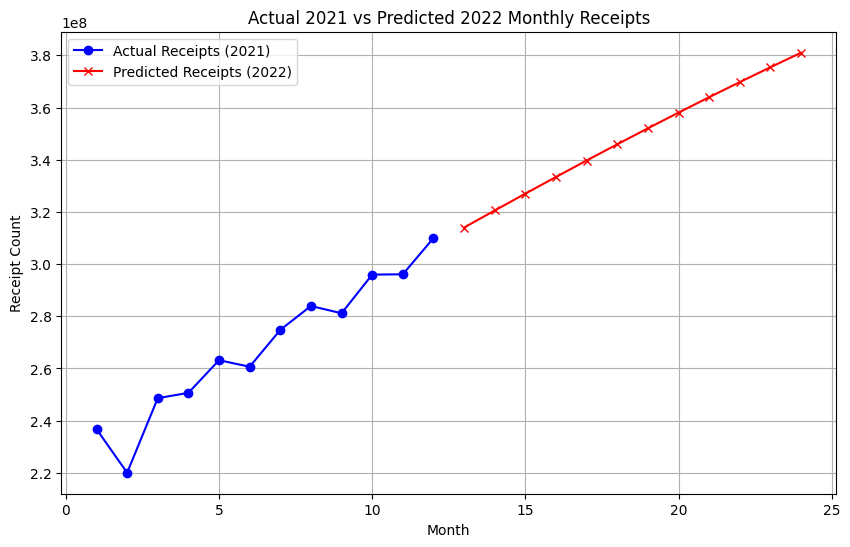

In [22]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from itertools import product

# Load data
data = pd.read_csv('../data/data_daily.csv', parse_dates=['# Date'], index_col='# Date')
monthly_data = data['Receipt_Count'].resample('M').sum()

# Scale the data
min_val = monthly_data.min()
max_val = monthly_data.max()

def custom_scale(data, min_val, max_val):
    return (data - min_val) / (max_val - min_val)

def custom_inverse_scale(scaled_data, min_val, max_val):
    return scaled_data * (max_val - min_val) + min_val

scaled_monthly_data = custom_scale(monthly_data.values, min_val, max_val)

# Prepare the dataset
X = np.array([[i] for i in range(1, len(scaled_monthly_data) + 1)])  # Month index
y = scaled_monthly_data

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)

# Reshape X_train_tensor for LSTM [batch_size, time_step, input_size]
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1).to(device)  # Add one dimension for the sequence
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1).to(device)  # Add one dimension for the target

X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1).to(device)  # Add one dimension for the sequence
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1).to(device)  # Add one dimension for the target

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.num_layers = num_layers
        self.hidden_size = hidden_size
    
    def forward(self, x):
        # Initialize hidden state and cell state with the correct size
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])  # Take the last output
        return out

# Hyperparameter grid
hidden_sizes = [100, 500, 1000]
num_layers_list = [1, 2]
learning_rates = [0.001, 0.0005]
epochs = 50
patience = 10  # Early stopping patience

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()

# For tracking the best model and best loss
best_val_loss = float('inf')
best_hyperparameters = None
best_model_path = 'best_model.pth'

# Grid search over hyperparameters
for hidden_size, num_layers, learning_rate in product(hidden_sizes, num_layers_list, learning_rates):
    print(f'Training model with hidden_size={hidden_size}, num_layers={num_layers}, learning_rate={learning_rate}')
    
    # Initialize model and optimizer for each combination of hyperparameters
    model = LSTMModel(input_size=1, hidden_size=hidden_size, output_size=1, num_layers=num_layers).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Training loop with validation and early stopping
    train_losses = []
    val_losses = []
    early_stop_count = 0

    for epoch in range(epochs):
        model.train()
        outputs = model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Validation
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)
        
        train_losses.append(loss.item())
        val_losses.append(val_loss.item())
        
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}, Val Loss: {val_loss.item():.6f}')
        
        # Early stopping check
        if val_loss.item() < best_val_loss:
            best_val_loss = val_loss.item()
            early_stop_count = 0
            best_hyperparameters = (hidden_size, num_layers, learning_rate)
            # Save the entire model
            torch.save(model, best_model_path)
        else:
            early_stop_count += 1
            if early_stop_count >= patience:
                print(f"Early stopping at epoch {epoch+1}. Best validation loss: {best_val_loss:.6f}")
                break

# After grid search, load the best model
best_model = torch.load(best_model_path)

print(f"Best hyperparameters: hidden_size={best_hyperparameters[0]}, num_layers={best_hyperparameters[1]}, learning_rate={best_hyperparameters[2]}")

# Predict future months (for example, 2022)
with torch.no_grad():
    best_model.eval()
    future_months = np.array([[i] for i in range(len(monthly_data) + 1, len(monthly_data) + 13)])  # Predicting for 2022
    future_months_tensor = torch.tensor(future_months, dtype=torch.float32).unsqueeze(1).to(device)
    predicted_scaled_receipts = best_model(future_months_tensor).cpu().numpy()
    predicted_receipts = custom_inverse_scale(predicted_scaled_receipts, min_val, max_val)


# Visualization: Actual 2021 vs Predicted 2022
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(monthly_data)+1), monthly_data.values, label='Actual Receipts (2021)', marker='o', color='blue')
plt.plot(range(len(monthly_data)+1, len(monthly_data)+13), predicted_receipts, label='Predicted Receipts (2022)', marker='x', color='red')
plt.title('Actual 2021 vs Predicted 2022 Monthly Receipts')
plt.xlabel('Month')
plt.ylabel('Receipt Count')
plt.grid(True)
plt.legend()
plt.show()
